In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras
from pprint import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


for module in np, pd, sklearn, mpl, tf, keras:
    print(module.__name__, module.__version__)
print(sys.version_info)

numpy 1.17.4
pandas 0.25.3
sklearn 0.22
matplotlib 3.1.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf
sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)


## 1.获取并处理数据

### 1.1 读取数据

In [2]:
input_filepath = "./shakespeare.txt"

with open(input_filepath, "r") as f:
    text = f.read()

print(len(text))
pprint(text[:100])

1115394
('First Citizen:\n'
 'Before we proceed any further, hear me speak.\n'
 '\n'
 'All:\n'
 'Speak, speak.\n'
 '\n'
 'First Citizen:\n'
 'You')


### 1.2 生成词表

In [3]:
vocab =sorted(set(text))  # 给字符排序
print(vocab, len(vocab))

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 65


### 1.3 构造词表映射

In [4]:
# build mapping char -> id
char2idx = {char:idx for idx, char in enumerate(vocab)}
print(char2idx)

idx2char = np.array(vocab)
print(idx2char)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


### 1.4 将文本数据集转换为ID数据集

In [5]:
text_as_int = np.array([char2idx[c] for c in text])
print(text_as_int[:10])
print(text[:10])

[18 47 56 57 58  1 15 47 58 47]
First Citi


### 1.5 将ID数据集转为dataset，并设定句子长度

In [6]:
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
seq_length = 100   # 设置句子长度（并不是以自然的句子方式结尾，而是限定长度）
seq_dataset = char_dataset.batch(
    seq_length+1, # 训练集与目标集要错一位进行预测
    drop_remainder=True)  # 最后一批如果长度不满足seq_length + 1则舍去

for ch_id in char_dataset.take(1):
    print(ch_id, idx2char[ch_id.numpy()])
    
for seq_id in seq_dataset.take(1):
    print(seq_id)
    print(repr("".join(idx2char[seq_id.numpy()])))

tf.Tensor(18, shape=(), dtype=int32) F
tf.Tensor(
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1], shape=(101,), dtype=int32)
'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### 1.6 划分数据集为train_data和_train_labels

In [7]:
def split_input_target(id_text):
    """ abcde -> abcd(input), bcde(output) """
    return id_text[0:-1], id_text[1:]

seq_dataset = seq_dataset.map(split_input_target)

for item in seq_dataset.take(1): # 解包
    print("Input: ")
    print(item[0].numpy())
    print("Output: ")
    print(item[1].numpy())

Input: 
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59]
Output: 
[47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43  1
 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43 39
 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49  6
  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0
 37 53 59  1]


In [8]:
batch_size = 64
buffer_size = 10000

seq_dataset = seq_dataset.shuffle(buffer_size).batch(
    batch_size, drop_remainder=True)

for item in seq_dataset.take(1):
    print(item)

(<tf.Tensor: id=61, shape=(64, 100), dtype=int32, numpy=
array([[63,  1, 42, ..., 43, 61, 57],
       [30, 21, 34, ...,  1, 46, 39],
       [42,  1, 58, ..., 63, 53, 59],
       ...,
       [57, 47, 52, ..., 42, 53, 53],
       [ 1, 57, 53, ..., 53, 52,  1],
       [52,  1, 51, ..., 56, 43,  5]])>, <tf.Tensor: id=62, shape=(64, 100), dtype=int32, numpy=
array([[ 1, 42, 53, ..., 61, 57, 12],
       [21, 34, 17, ..., 46, 39, 52],
       [ 1, 58, 53, ..., 53, 59,  1],
       ...,
       [47, 52, 41, ..., 53, 53, 56],
       [57, 53, 53, ..., 52,  1, 58],
       [ 1, 51, 63, ..., 43,  5, 57]])>)


## 2. RNN建模

### 2.1 建模

In [9]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 200

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = keras.models.Sequential([
        keras.layers.Embedding(vocab_size,
                               embedding_dim,
                               batch_input_shape=[batch_size, None]),
        keras.layers.LSTM(units=rnn_units,
                          stateful=True,
                          recurrent_initializer="glorot_uniform",
                          return_sequences=True),
        keras.layers.Dense(vocab_size)
    ])
    return model

model = build_model(vocab_size=vocab_size,
                    embedding_dim=embedding_dim,
                    rnn_units=rnn_units,
                    batch_size=batch_size)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           16640     
_________________________________________________________________
lstm (LSTM)                  (64, None, 200)           365600    
_________________________________________________________________
dense (Dense)                (64, None, 65)            13065     
Total params: 395,305
Trainable params: 395,305
Non-trainable params: 0
_________________________________________________________________


### 2.2 使用初始模型进行预测 

In [10]:
for input_example_batch, target_example_batch in seq_dataset.take(1):
    # 利用初始化的模型进行预测
    example_batch_predictions = model(input_example_batch)  
    print(example_batch_predictions.shape)

(64, 100, 65)


In [11]:
# random sampling
# greedy, random 贪心采样与随机采样
# (100, 65) -> (100, 1)
# tf.random.categorical输入维度必须为二维
sample_indices = tf.random.categorical(logits=example_batch_predictions[0],
                                       num_samples=1)
print(sample_indices)   
sample_indices = tf.squeeze(sample_indices, axis=-1)
print(sample_indices)

tf.Tensor(
[[60]
 [45]
 [31]
 [54]
 [17]
 [50]
 [20]
 [ 4]
 [13]
 [ 6]
 [30]
 [51]
 [23]
 [18]
 [ 9]
 [32]
 [29]
 [36]
 [38]
 [51]
 [ 5]
 [31]
 [54]
 [64]
 [30]
 [64]
 [48]
 [50]
 [23]
 [58]
 [42]
 [24]
 [14]
 [15]
 [ 8]
 [17]
 [ 0]
 [46]
 [48]
 [32]
 [20]
 [17]
 [53]
 [24]
 [16]
 [53]
 [41]
 [34]
 [ 4]
 [59]
 [32]
 [28]
 [48]
 [ 1]
 [10]
 [ 6]
 [49]
 [ 1]
 [62]
 [35]
 [ 1]
 [12]
 [24]
 [12]
 [ 2]
 [34]
 [24]
 [38]
 [48]
 [ 7]
 [41]
 [36]
 [ 7]
 [39]
 [34]
 [31]
 [35]
 [47]
 [22]
 [59]
 [23]
 [51]
 [18]
 [31]
 [34]
 [ 1]
 [58]
 [10]
 [50]
 [56]
 [51]
 [12]
 [56]
 [38]
 [40]
 [43]
 [26]
 [41]
 [52]
 [54]], shape=(100, 1), dtype=int64)
tf.Tensor(
[60 45 31 54 17 50 20  4 13  6 30 51 23 18  9 32 29 36 38 51  5 31 54 64
 30 64 48 50 23 58 42 24 14 15  8 17  0 46 48 32 20 17 53 24 16 53 41 34
  4 59 32 28 48  1 10  6 49  1 62 35  1 12 24 12  2 34 24 38 48  7 41 36
  7 39 34 31 35 47 22 59 23 51 18 31 34  1 58 10 50 56 51 12 56 38 40 43
 26 41 52 54], shape=(100,), dtype=int64)


In [12]:
print("Input: ", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Output: ", repr("".join(idx2char[target_example_batch[0]])))
print()
print("Prediction: ", repr("".join(idx2char[sample_indices])))

Input:  ', I spy some pity in thy looks:\nO, if thine eye be not a flatterer,\nCome thou on my side, and entrea'

Output:  ' I spy some pity in thy looks:\nO, if thine eye be not a flatterer,\nCome thou on my side, and entreat'

Prediction:  "vgSpElH&A,RmKF3TQXZm'SpzRzjlKtdLBC.E\nhjTHEoLDocV&uTPj :,k xW ?L?!VLZj-cX-aVSWiJuKmFSV t:lrm?rZbeNcnp"


In [13]:
def loss(labels, logits):
    return keras.losses.sparse_categorical_crossentropy(
        labels,
        logits,
        from_logits=True) # 最后一层神经网络中没有激活函数softmax，
                          # 所以不是归一化形式

model.compile(optimizer="adam", loss=loss)
example_loss = loss(target_example_batch, example_batch_predictions)
print(target_example_batch.shape)
print(example_batch_predictions.shape)
print(example_loss.shape)
print(example_loss.numpy().mean())

(64, 100)
(64, 100, 65)
(64, 100)
4.174729


In [14]:
output_dir = "./text_generation_checkpoints"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
# 使用多个checkpoint文件记录每个epoch中的参数值，以前只用checkpoint记录所有
# epoch中效果最好的模型，并且把参数记录在一个h5文件中，这里有所不同
checkpoint_prefix = os.path.join(output_dir, "ckpt_{epoch}")
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

epochs = 10
history = model.fit(seq_dataset, 
                    epochs=epochs,
                    callbacks=[checkpoint_callback])

Epoch 1/10
172/172 [==============================] - 49s 287ms/step - loss: 2.8063
Epoch 2/10
172/172 [==============================] - 51s 297ms/step - loss: 2.1752
Epoch 3/10
172/172 [==============================] - 55s 322ms/step - loss: 1.9973
Epoch 4/10
172/172 [==============================] - 59s 346ms/step - loss: 1.8886
Epoch 5/10
172/172 [==============================] - 58s 337ms/step - loss: 1.8115
Epoch 6/10
172/172 [==============================] - 57s 333ms/step - loss: 1.7538
Epoch 7/10
172/172 [==============================] - 59s 340ms/step - loss: 1.7084
Epoch 8/10
172/172 [==============================] - 60s 347ms/step - loss: 1.6731
Epoch 9/10
172/172 [==============================] - 60s 348ms/step - loss: 1.6428
Epoch 10/10
172/172 [==============================] - 59s 342ms/step - loss: 1.6168


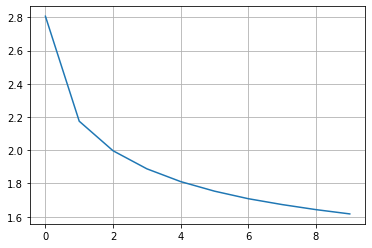

In [15]:
history.history.keys()
def plot_loss_curves(history):
    plt.plot(range(epochs), history.history["loss"])
    plt.grid(True)
    plt.show()

plot_loss_curves(history)

## 3. 使用checkpoint载入模型

In [16]:
print(tf.train.latest_checkpoint(output_dir))

./text_generation_checkpoints\ckpt_10


In [17]:
model2 = build_model(vocab_size,
                     embedding_dim,
                     rnn_units,
                     batch_size=1)
model2.load_weights(tf.train.latest_checkpoint(output_dir))
model2.build(tf.TensorShape([1, None])) # model2.build([1, None])
                                        # 输入是一个变长
# start ch sequence A,
# A -> model -> b
# A.append(b) -> B
# B(Ab) -> model -> c
# b.append(c) -> C
# C(Abc) -> model -> ...
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 200)            365600    
_________________________________________________________________
dense_1 (Dense)              (1, None, 65)             13065     
Total params: 395,305
Trainable params: 395,305
Non-trainable params: 0
_________________________________________________________________


## 4.生成文本

In [24]:
def generate_text(model, start_string, num_generate=1000):
    input_eval = [char2idx[ch] for ch in start_string]
    input_eval = tf.expand_dims(input_eval, axis=0)
    
    text_generated = []
    model.reset_states()     # ???????????
    
    # temperature > 1, random 
    # temperature < 1, greedy
    temperature = 0.5
    
    for _ in range(num_generate):
        # 1. model inderence -> predictions
        # 2. sample -> ch -> text_generated.
        # 3. update input_eval
        
        # predictions : [batch_size, input_eval_len, vocab_size]
        predictions = model(input_eval)
        # predicions: logits -> softmax -> prob
        # softmax: e^xi
        # eg: 4, 2   e^4/(e^4 + e^2) = 0.88, e^2/(e^4 + e^2) = 0.12
        # eg: 2, 1   e^2/(e^2 + e) = 0.73, e/(e^2 + e) = 0.27
        predictions = predictions / temperature
        # predictions : [input_eval_len, vocab_size]
        predictions = tf.squeeze(predictions, 0)
        # prediction_ids: [input_eval_len, 1]
        # a b c -> b c d
        prediction_id = tf.random.categorical(predictions,
                                              num_samples=1)[-1, 0].numpy()
        text_generated.append(idx2char[prediction_id])
        input_eval = tf.expand_dims([prediction_id], 0)
    return start_string + "".join(text_generated)

new_text = generate_text(model2, "All: ")
print(new_text)

All: here do the hands, he and you deeming to and come:
If the compersed to my sugen and father
That shall the wind the chast of honour with a faure.

BIONDELLO:
I to my say the comes to be death,
And set the proud in the vein the sinds some street the of your great strock
To you will gable of my lag to men him:
The seech the court and the worst the dest of a bear and did as be the made of the shall have be enough to have
The plack is strain must the last the erest, and they son my for the mouth,
Where it marrichion of the for they hast
The rear of your treet love the father,
The bear the many son my strong the fortune to be to so still prince,
In the could not in the shall be true thee and matter man,
What the bore the mean the should not this love.

CAMILLO:
I that the shall than the pasting and here.

LADY CAPULET:
What you the such a more that see such advice me a light.

BRUTUS:
Nor chart our mind me here and pleased to suce
That the life, sir, the parter of chires
To make that I 